In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Preparations

In [2]:
import json
import os

### Mount Google Drive with raw data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
! ls /content/drive/MyDrive/Colab\ Notebooks/Spam_Detector/Enron_raw_data/dataset

test  test.csv	train  train.csv


### Install this project package from github

In [5]:
!rm -rf /content/spam_detector/
!git clone https://github.com/NataliaTarasovaNatoshir/spam_detector.git
%cd spam_detector/
!git pull origin master
!python setup.py install

Cloning into 'spam_detector'...
remote: Enumerating objects: 143, done.
remote: Counting objects: 100% (143/143), done.
remote: Compressing objects: 100% (108/108), done.
remote: Total 143 (delta 79), reused 97 (delta 33), pack-reused 0
Receiving objects: 100% (143/143), 19.69 KiB | 6.56 MiB/s, done.
Resolving deltas: 100% (79/79), done.
/content/spam_detector
From https://github.com/NataliaTarasovaNatoshir/spam_detector
 * branch            master     -> FETCH_HEAD
Already up to date.
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:502: UserWarning: The version specified ('') is an invalid version, this may not work as expected with newer versions of setuptools, pip, and PyPI. Please see PEP 440 for more details.
  "details." % version
running install
running bdist_egg
running egg_info
creating spam_detector.egg-info
writing spam_detector.egg-info/PKG-INFO
writing dependency_links to spam_detector.egg-info/dependency_links.txt
writing top-level names to spam_detector.egg-inf

In [6]:
# load config from package
with open("/content/spam_detector/spam_detector/config.json") as file:
  config = json.load(file)
config

{'dataset_build': {'raw_files_folder': '/content/drive/MyDrive/Colab Notebooks/Spam_Detector/Enron_raw_data/raw_files',
  'res_dataset_folder_name': '/content/drive/MyDrive/Colab Notebooks/Spam_Detector/Enron_raw_data/dataset',
  'test_share': 0.3},
 'funnel_approach': {'bert_app_score_max': 0.526,
  'bert_app_score_min': 0.502,
  'bert_epochs_num': 5,
  'bert_model_name': 'bert',
  'bert_threshold': 0.9992536,
  'bow_model_name': 'bow',
  'bow_threshold': 0.5135137500040693},
 'testing': {'recall_level': 0.99}}

# Compare Bag of Words and BERT predictions

In [8]:
# A dependency of the preprocessing for BERT inputs
!pip install -q -U "tensorflow-text==2.8.*"

# AdamW optimizer
!pip install -q tf-models-official==2.7.0

     |████████████████████████████████| 4.9 MB 5.2 MB/s 
     |████████████████████████████████| 462 kB 46.7 MB/s 
     |████████████████████████████████| 1.8 MB 5.3 MB/s 
     |████████████████████████████████| 1.1 MB 36.7 MB/s 
     |████████████████████████████████| 92 kB 10.5 MB/s 
     |████████████████████████████████| 237 kB 54.1 MB/s 
     |████████████████████████████████| 596 kB 45.9 MB/s 
     |████████████████████████████████| 352 kB 49.2 MB/s 
     |████████████████████████████████| 99 kB 9.3 MB/s 
     |████████████████████████████████| 43 kB 2.0 MB/s 
     |████████████████████████████████| 47.8 MB 1.5 MB/s 
     |████████████████████████████████| 1.2 MB 44.8 MB/s 


In [9]:
from spam_detector import quality_assessment
from spam_detector.models import bow_model, bert_model

In [10]:
# Bag of Words approach
bow = bow_model.BoWModel(
    load_from_file=True, 
    filepath='/content/drive/MyDrive/Colab Notebooks/Spam_Detector/models/optimal_bow.joblib')

bow_results = quality_assessment.run_experiment(config=config, model_name=bow.model_name, model=bow, return_predictions=True)

Loading the model from /content/drive/MyDrive/Colab Notebooks/Spam_Detector/models/optimal_bow.joblib
Model loaded successfully
Testing model optimal_bow

Loading test dataset
Test dataset size = 10105 entries
Share of spam = 0.5090

Generating predictions
Predictions generated

Total inference time: 0:00:03.463687
Inference time per 1000 entries: 0:00:00.342770

Binary classification metrics:
roc-auc score: 0.9965
At recall 0.9899 precision = 0.9738

Confusion matrix:
[[4825  137]
 [  52 5091]]


In [11]:
# check that a model loaded from file behaves in the same way
bert = bert_model.BERTModel(
    load_from_folder=True, folder='/content/drive/MyDrive/Colab Notebooks/Spam_Detector/models/small_bert')

bert_results = quality_assessment.run_experiment(config=config, 
                                                model_name=bert.model_name, 
                                                model=bert, return_predictions=True) 

Loading the model from /content/drive/MyDrive/Colab Notebooks/Spam_Detector/models/small_bert
Model loaded successfully
Testing model small_bert

Loading test dataset
Test dataset size = 10105 entries
Share of spam = 0.5090

Generating predictions
Processing dataset for prediction
Applying the model
Predictions generated

Total inference time: 0:01:15.980648
Inference time per 1000 entries: 0:00:07.519114

Binary classification metrics:
roc-auc score: 0.9987
At recall 0.9899 precision = 0.9903

Confusion matrix:
[[4912   50]
 [  52 5091]]


In [12]:
assert np.all(bow_results['labels'] == bert_results['labels']), 'Labels are unequal'

In [13]:
pred_df = pd.DataFrame({'labels': bow_results['labels'], 
                        'bow_score': bow_results['predictions'], 
                        'bert_score': bert_results['predictions'].numpy().flatten()})

pred_df['bow_labels'] = pred_df['bow_score'] >= bow_results['quality_metrics']['threshold']
pred_df['bert_labels'] = pred_df['bert_score'] >= bert_results['quality_metrics']['threshold']

In [14]:
bow_results['quality_metrics']['threshold'], bert_results['quality_metrics']['threshold']

(0.5135137500040693, 0.9992536)

In [15]:
pred_df.head()

,labels,bow_score,bert_score,bow_labels,bert_labels
0,0,0.487623,0.000005,False,False
1,0,0.491356,0.000015,False,False
2,0,0.456816,0.000004,False,False
3,0,0.500051,0.000010,False,False
4,0,0.459036,0.000005,False,False


## Analyze cases where two model disagree

In [16]:
pred_df['is_diff'] = pred_df['bow_labels'] != pred_df['bert_labels']

In [17]:
pred_df['bert_score_gr'] = pd.cut(pred_df.bow_score, np.percentile(pred_df.bow_score, range(0, 110, 10)), include_lowest=True)
assert len(pred_df[pred_df['bert_score_gr'].isnull()]) == 0
pred_df.head()

,labels,bow_score,bert_score,bow_labels,bert_labels,is_diff,bert_score_gr
0,0,0.487623,0.000005,False,False,False,"(0.482, 0.493]"
1,0,0.491356,0.000015,False,False,False,"(0.482, 0.493]"
2,0,0.456816,0.000004,False,False,False,"(0.387, 0.463]"
3,0,0.500051,0.000010,False,False,False,"(0.493, 0.502]"
4,0,0.459036,0.000005,False,False,False,"(0.387, 0.463]"


In [18]:
pred_df['bow_miss'] = pred_df['bow_labels'] != pred_df['labels']
pred_df['bert_miss'] = pred_df['bert_labels'] != pred_df['labels']

In [19]:
stat = pred_df.groupby('bert_score_gr').aggregate({'labels': len, 'is_diff': sum, 
                                                   'bow_miss': sum,
                                                   'bert_miss': sum}).reset_index()
stat

,bert_score_gr,labels,is_diff,bow_miss,bert_miss
0,"(0.387, 0.463]",1011,0,0,0
1,"(0.463, 0.482]",1010,0,0,0
2,"(0.482, 0.493]",1012,1,1,2
3,"(0.493, 0.502]",1009,7,3,8
4,"(0.502, 0.516]",1011,125,110,43
5,"(0.516, 0.522]",1010,72,51,33
6,"(0.522, 0.526]",1010,20,17,9
7,"(0.526, 0.531]",1012,4,5,5
8,"(0.531, 0.538]",1010,3,1,2
9,"(0.538, 0.571]",1010,1,1,0


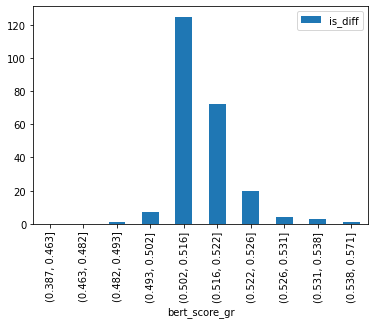

In [20]:
stat.plot.bar(x='bert_score_gr', y='is_diff')
plt.show()

The majority of cases where two models predict different labels have the score of Bag of Words model between 0.502 and 0.526. 

BERT model is provides more accurate predictions.  

## Combine two models

Possible solution is to combine two models to achieve better quality with shorter inference time.


In [25]:
bow_scores = pred_df['bow_score'].values
bow_labels = pred_df['bow_labels'].values
bert_labels = pred_df['bert_labels'].values

use_bert_index = (bow_scores > 0.502) & (bow_scores <= 0.526)

In [26]:
set(pred_df.iloc[use_bert_index, :].bert_score_gr)

{Interval(0.502, 0.516, closed='right'),
 Interval(0.516, 0.522, closed='right'),
 Interval(0.522, 0.526, closed='right')}

In [27]:
combined_labels = bow_labels
combined_labels[use_bert_index] = bert_labels[use_bert_index]

In [28]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix
pr = precision_score(pred_df['labels'], combined_labels)
rc = recall_score(pred_df['labels'], combined_labels)
cm = confusion_matrix(pred_df['labels'], combined_labels)

print('Combined model metrics:')
print('At recall {0:.4f} precision = {1:.4f}\n'.format(rc, pr))
print('Confusion matrix:')
print(cm)

Combined model metrics:
At recall 0.9905 precision = 0.9903

Confusion matrix:
[[4912   50]
 [  49 5094]]


# Build a combined model

Two-step model:


1.   Apply fast Bag of Words approach
2.   For object with score 0.502-0.526 - apply BERT
3. Label objects for Bag of Words and BERT with their correct thresholds



In [8]:
from spam_detector.models import funnel_model

In [9]:
config

{'dataset_build': {'raw_files_folder': '/content/drive/MyDrive/Colab Notebooks/Spam_Detector/Enron_raw_data/raw_files',
  'res_dataset_folder_name': '/content/drive/MyDrive/Colab Notebooks/Spam_Detector/Enron_raw_data/dataset',
  'test_share': 0.3},
 'funnel_approach': {'bert_app_score_max': 0.526,
  'bert_app_score_min': 0.502,
  'bert_epochs_num': 5,
  'bert_model_name': 'bert',
  'bert_threshold': 0.9992536,
  'bow_model_name': 'bow',
  'bow_threshold': 0.5135137500040693},
 'testing': {'recall_level': 0.99}}

In [10]:
funnel = funnel_model.FunnelModel(config, model_name='funnel_model', load_from_folder=True, 
                            folder='/content/drive/MyDrive/Colab Notebooks/Spam_Detector/models/funnel_model')

Loading the model from /content/drive/MyDrive/Colab Notebooks/Spam_Detector/models/funnel_model
Loading model for Bag of Words approach
Loading the model from /content/drive/MyDrive/Colab Notebooks/Spam_Detector/models/funnel_model/bow.joblib
Model loaded successfully
Loading the model for Transformers approach
Loading the model from /content/drive/MyDrive/Colab Notebooks/Spam_Detector/models/funnel_model/bert
Model loaded successfully
Model loaded successfully


In [11]:
from spam_detector import quality_assessment
funnel_results = quality_assessment.run_experiment(config=config, 
                                                   model_name=funnel.model_name, 
                                                   model=funnel, return_predictions=False, 
                                                   use_labels=True)

Testing model funnel_model

Loading test dataset
Test dataset size = 10105 entries
Share of spam = 0.5090

Generating predictions
Processing dataset for prediction
Applying the model
Predictions generated

Total inference time: 0:00:22.277667
Inference time per 1000 entries: 0:00:02.204618

Binary classification metrics:
At recall 0.9905 precision = 0.9903

Confusion matrix:
[[4912   50]
 [  49 5094]]


# Notes on usage for real-life tasks

Two classes in this dataset are balanced to facilitate easier training. In practice they are extremely unbalanced - the majority of emails are ham while only a small share are spam.
The percentage of emails where the faster BERT approach is required is different for spam and ham classes. in fact, for spam messages BERT approach is needed twice as often as for ham message.

This means that in practice for the majority of messages only the fast Bag of Words model will be used, which makes the funnel approach all the more efficient in terms of speed and precision. 

In [23]:
pred_df['use_bert'] = (pred_df['bow_score'] > 0.502) & (pred_df['bow_score'] <= 0.526)
pred_df.groupby('labels').aggregate({'bow_score': len, 'use_bert': np.mean})

,bow_score,use_bert
labels,,
0,4962,0.179162
1,5143,0.388295
